# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Rescaling
from keras import Model

tf.__version__

'2.12.0'

### Setup hyperparameters

We need to set-up N_FFT and HOP_LENGTH properly so that we have a properly sized spectrograms.

In [2]:
SLICE_DURATION = 0.5
SAMPLING_RATE = 22500
N_FFT = 2048
HOP_LENGTH = N_FFT // 8
N_MELS=512
MEL_MIN_HZ = 0
MEL_MAX_HZ = SAMPLING_RATE / 2

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
N_KERNELS = 10
N_FILTERS = 1

N_EPOCHS = 50

In [3]:
def get_sliced_audio_samples(path, slice_duration, sampling_rate):
    """
    Decode the audio and cut audio into samples of `slice_duration`.
    Return an array of sliced audios.
    """
    y, sr = librosa.load(path, sr=sampling_rate, mono=True)
    samples_per_slice = int(slice_duration * sampling_rate)
    num_slices = int(len(y) / samples_per_slice)
    rounded_num_samples = num_slices * samples_per_slice
    rounded_y = y[:rounded_num_samples]
    return rounded_y.reshape(num_slices, samples_per_slice)

Then we will call the function `get_sliced_audio_samples` to slice the audio.

In [4]:
slices = get_sliced_audio_samples("males/0.wav", SLICE_DURATION, SAMPLING_RATE)

We pick-up a random slice for visualization.

In [5]:
random_slice = slices[np.random.randint(len(slices))]

We will plot the random slice below.

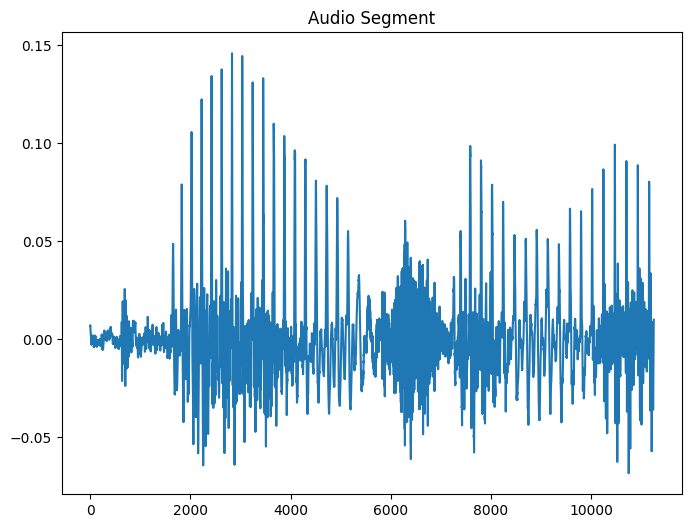

In [6]:
plt.figure(figsize=(8, 6))
plt.title('Audio Segment')
plt.plot(random_slice)

In [7]:
def get_stft(audio_slice):
    """
    Get short-term fourier transform to a slice.
    """
    window = np.hanning(N_FFT)
    spectrogram = librosa.stft(audio_slice, n_fft=N_FFT, hop_length=HOP_LENGTH, window=window)
    return np.abs(spectrogram)

In [8]:
def plot_stft(ft, sampling_rate):
    """
    Plot the short-term fourier transform spectrogram.
    """
    db = librosa.amplitude_to_db(ft, ref=np.max)
    librosa.display.specshow(db, sr=sampling_rate, y_axis='log', x_axis='time')

Get short term fourier transform of the random slice and plot the spectrogram.

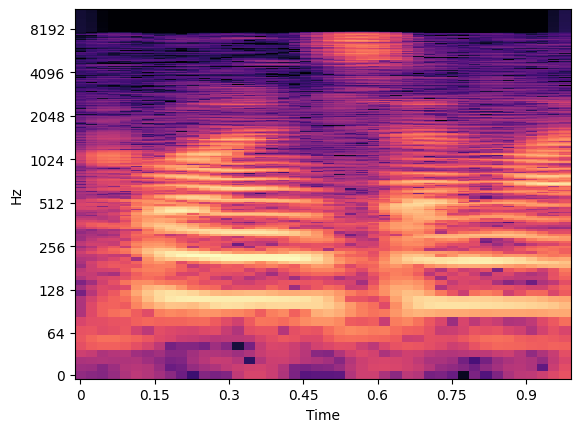

In [9]:
stft = get_stft(random_slice)
plot_stft(stft, SAMPLING_RATE)

In [10]:
def get_audio_slices_stft(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    """
    Get spectrogram's of an audio file after slicing.
    """
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_stft(norm) for norm in audio_slices])

Get spectrograms of a single audio divided into slices.

In [11]:
stft = get_audio_slices_stft("males/0.wav")
stft.shape, stft[0]

((11, 1025, 44),
 array([[5.02947867e-01, 4.10338908e-01, 2.19858512e-01, ...,
         1.77299783e-01, 2.32145220e-01, 2.24364296e-01],
        [5.34973085e-01, 4.58131641e-01, 2.71615654e-01, ...,
         1.47755355e-01, 1.01530790e-01, 1.29609093e-01],
        [5.24474740e-01, 4.74888742e-01, 3.18895251e-01, ...,
         1.41565099e-01, 1.01138003e-01, 1.13104239e-01],
        ...,
        [7.63271237e-04, 6.51112699e-04, 3.80949525e-04, ...,
         1.13389076e-04, 3.65803397e-04, 6.09521579e-04],
        [7.63264892e-04, 6.51106297e-04, 3.80946818e-04, ...,
         1.13425856e-04, 3.65813845e-04, 6.09526876e-04],
        [7.63264252e-04, 6.51109498e-04, 3.80952901e-04, ...,
         1.13401264e-04, 3.65794229e-04, 6.09519135e-04]], dtype=float32))

Get the shape of the spectrogram slice.

In [12]:
STFT_SHAPE = stft.shape[-2:]
STFT_SHAPE

(1025, 44)

# Create Train and Test Splits

Define the data directories.

In [13]:
male_voice_dir = "males"
female_voice_dir = "females"

In [14]:
def get_file_paths_from_dir(path):
    """
    Get files from `path`.
    """
    files = []

    for (_, _, filenames) in os.walk(path):
        files += [path + "/" + filename for filename in filenames]

    return files

Get file paths and labels from both of the data directories.

In [15]:
file_paths = []
labels = []

male_voice_files = get_file_paths_from_dir(male_voice_dir)
file_paths += male_voice_files
labels += [1.0] * len(male_voice_files)

female_voice_files = get_file_paths_from_dir(female_voice_dir)
file_paths += female_voice_files
labels += [0.0] * len(female_voice_files)

Divide the data and labels into train and test splits.

In [16]:
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.1,
    shuffle=True,
    random_state=42
)

len(train_files), len(val_files), len(train_labels), len(val_labels)

(5393, 600, 5393, 600)

# Models

## STFT Based Model

In [17]:
def audio_preprocess_stft(file_path, label):
    """
    Divide the audio into slices, get short term fourier transform
    Then expand dimension.
    Return expanded spectrograms and labels.
    """
    slice_stfts = get_audio_slices_stft(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_stfts))
    expanded_stfts = np.array([tf.expand_dims(slice_stft, -1) for slice_stft in slice_stfts])
    return expanded_stfts, labels

In [18]:
def set_tensor_shapes_stft(slice_data, label):
    """
    Set shape of tensors, we need this because after flatmap
    We will lose shape information.
    """
    slice_data.set_shape(STFT_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

Below we will,
- Create train datasets using the file paths and labels.
- Flat map the dataset to slice the audio file and create a flattened array of spectrograms.
- After slicing the data will lose dimensionality information.
- Because we lose dimensional information, we need to set the tensor shapes using `set_tensor_shapes_stft`.

In [19]:
train_dataset_stft = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_stft = train_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_stft = train_dataset_stft.map(set_tensor_shapes_stft)

train_dataset_stft = train_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

Below we will,
- Create test datasets using the file paths and labels.
- Flat map the dataset to slice the audio file and create a flattened array of spectrograms.
- After slicing the data will lose dimensionality information.
- Because we lose dimensional information, we need to set the tensor shapes using `set_tensor_shapes_stft`.

In [20]:
val_dataset_stft = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_stft = val_dataset_stft.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_stft,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_stft = val_dataset_stft.map(set_tensor_shapes_stft)

val_dataset_stft = val_dataset_stft\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

Create a model using Convolutional Neural Network cells.

In [21]:
tf.random.set_seed(42)

inputs = Input(shape=STFT_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="cnn_model")(x)
model_cnn_stft = Model(inputs, outputs)

Compile the CNN model.

In [68]:
model_cnn_stft.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Set up an Early Stopping Callback to stop when we stopped improving.
Also recover the best weights.

In [69]:
early_stopping_cb_cnn_stft = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

Fit the model and save the history.

In [70]:
history_cnn_stft = model_cnn_stft.fit(train_dataset_stft,
                        epochs=N_EPOCHS,
                        validation_data=val_dataset_stft,
                        callbacks=[early_stopping_cb_cnn_stft])

Epoch 1/50
568/568 [==============================] - 160s 88ms/step - loss: 0.4936 - accuracy: 0.7940 - val_loss: 0.4929 - val_accuracy: 0.8167
Epoch 2/50
568/568 [==============================] - 39s 68ms/step - loss: 0.4213 - accuracy: 0.8335 - val_loss: 0.4396 - val_accuracy: 0.8362
Epoch 3/50
568/568 [==============================] - 41s 72ms/step - loss: 0.3827 - accuracy: 0.8457 - val_loss: 0.4149 - val_accuracy: 0.8405
Epoch 4/50
568/568 [==============================] - 39s 69ms/step - loss: 0.3695 - accuracy: 0.8516 - val_loss: 0.4045 - val_accuracy: 0.8422
Epoch 5/50
568/568 [==============================] - 39s 69ms/step - loss: 0.3614 - accuracy: 0.8543 - val_loss: 0.3936 - val_accuracy: 0.8432
Epoch 6/50
568/568 [==============================] - 36s 63ms/step - loss: 0.3554 - accuracy: 0.8563 - val_loss: 0.3898 - val_accuracy: 0.8448
Epoch 7/50
568/568 [==============================] - 39s 69ms/step - loss: 0.3522 - accuracy: 0.8569 - val_loss: 0.3870 - val_accuracy

Evaluate the model.

In [71]:
model_cnn_stft.evaluate(val_dataset_stft)

65/65 [==============================] - 1s 15ms/step - loss: 0.3649 - accuracy: 0.8554


[0.3648962378501892, 0.8553673624992371]

Save the model in the specified location.

In [72]:
model_cnn_stft.save("saved_models/cnn_stft_model")

INFO:tensorflow:Assets written to: saved_models/cnn_stft_model/assets


INFO:tensorflow:Assets written to: saved_models/cnn_stft_model/assets


## Mel Spectogram Based Model

In [21]:
def get_mel_spec(audio_slice):
    """
    Get mel-spectrogram of the audio slice.
    """
    window = np.hanning(N_FFT)
    return librosa.feature.melspectrogram(
        y=audio_slice,
        sr=SAMPLING_RATE,
        n_fft=N_FFT,
        window=window,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        fmin=MEL_MIN_HZ,
        fmax=MEL_MAX_HZ
    )


In [22]:
def plot_mel_spec(mel_spec, sampling_rate=SAMPLING_RATE, f_max=MEL_MAX_HZ):
    """
    Plot the mel spectrogram
    """
    fig, ax = plt.subplots()
    spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(
        spec_db,
        x_axis='time',
        y_axis='mel',
        sr=sampling_rate,
        fmax=f_max,
        ax=ax
    )
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')

Get and plot mel spectrogram of the random slice.

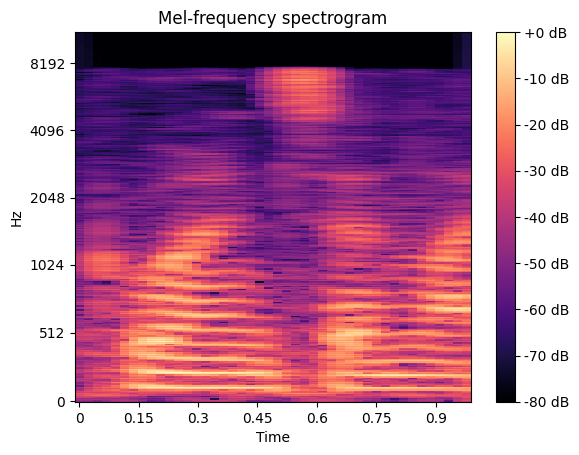

In [23]:
mel_spec_slice = get_mel_spec(random_slice)
plot_mel_spec(mel_spec_slice)

In [24]:
def get_audio_slices_mel_spec(path, slice_duration=SLICE_DURATION, sampling_rate=SAMPLING_RATE):
    """
    Get mel spectrogram of the audio file's slices.
    """
    audio_slices = get_sliced_audio_samples(path, slice_duration, sampling_rate)
    return np.array([get_mel_spec(audio_slice) for audio_slice in audio_slices])

Get mel specs of the audio slices with the specified file path.

In [25]:
mel_spec = get_audio_slices_mel_spec("males/0.wav")
mel_spec.shape, mel_spec[0]

((11, 512, 44),
 array([[1.3865652e-02, 1.0168502e-02, 3.5742589e-03, ..., 1.0577010e-03,
         4.9942691e-04, 8.1385561e-04],
        [3.0000579e-02, 2.2001198e-02, 7.7334866e-03, ..., 2.2885068e-03,
         1.0805909e-03, 1.7609081e-03],
        [2.6653582e-02, 2.1851948e-02, 9.8537719e-03, ..., 1.9418640e-03,
         9.9114038e-04, 1.2395503e-03],
        ...,
        [5.3025701e-08, 3.8586936e-08, 1.3208908e-08, ..., 1.1694198e-09,
         1.2168350e-08, 3.3783845e-08],
        [5.3023363e-08, 3.8585434e-08, 1.3208493e-08, ..., 1.1699423e-09,
         1.2173836e-08, 3.3799115e-08],
        [5.3027730e-08, 3.8588599e-08, 1.3209573e-08, ..., 1.1704059e-09,
         1.2178660e-08, 3.3812540e-08]], dtype=float32))

Get the mel spectrogram shape and store it into a variable.

In [26]:
MEL_SPEC_SHAPE = mel_spec.shape[-2:]
MEL_SPEC_SHAPE

(512, 44)

In [27]:
def audio_preprocess_mel_spec(file_path, label):
    """
    Divide the audio into slices, get mel spectrograms.
    Then expand dimension.
    Return expanded spectrograms and labels.
    """
    slice_mel_specs = get_audio_slices_mel_spec(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_mel_specs))
    expanded_slice_mel_specs = np.array([tf.expand_dims(slice_mel_spec, -1) for slice_mel_spec in slice_mel_specs])
    return expanded_slice_mel_specs, labels

In [28]:
def set_tensor_shapes_mel_spec(slice_data, label):
    """
    Set shape of tensors, we need this because after flatmap
    We will lose shape information.
    """
    slice_data.set_shape(MEL_SPEC_SHAPE + (1,))
    label.set_shape(())
    return slice_data, label

Below we will,
- Create train datasets using the file paths and labels.
- Flat map the dataset to slice the audio file and create a flattened array of spectrograms.
- After slicing the data will lose dimensionality information.
- Because we lose dimensional information, we need to set the tensor shapes using `set_tensor_shapes_mel_spec`.

In [29]:
train_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset_mel_spec = train_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_dataset_mel_spec = train_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

train_dataset_mel_spec = train_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

Below we will,
- Create test datasets using the file paths and labels.
- Flat map the dataset to slice the audio file and create a flattened array of spectrograms.
- After slicing the data will lose dimensionality information.
- Because we lose dimensional information, we need to set the tensor shapes using `set_tensor_shapes_mel_spec`.

In [30]:
val_dataset_mel_spec = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset_mel_spec = val_dataset_mel_spec.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_spec,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_dataset_mel_spec = val_dataset_mel_spec.map(set_tensor_shapes_mel_spec)

val_dataset_mel_spec = val_dataset_mel_spec\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

Create a model using Convolutional Neural Network cells.

In [32]:
tf.random.set_seed(42)

inputs = Input(shape=MEL_SPEC_SHAPE + (1,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="mel_spec_model")(x)
model_cnn_mel_spec = Model(inputs, outputs)

Compile the CNN model.

In [84]:
model_cnn_mel_spec.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Set up an Early Stopping Callback to stop when we stopped improving. Also recover the best weights.

In [85]:
early_stopping_cb_cnn_mel_spec = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

Fit the model and save the stories.

In [86]:
history_cnn_mel_spec = model_cnn_mel_spec.fit(train_dataset_mel_spec,
                        epochs=N_EPOCHS,
                        validation_data=val_dataset_mel_spec,
                        callbacks=[early_stopping_cb_cnn_mel_spec])

Epoch 1/50
568/568 [==============================] - 863s 183ms/step - loss: 0.6185 - accuracy: 0.6842 - val_loss: 0.5562 - val_accuracy: 0.7920
Epoch 2/50
568/568 [==============================] - 21s 37ms/step - loss: 0.4562 - accuracy: 0.8058 - val_loss: 0.4673 - val_accuracy: 0.8078
Epoch 3/50
568/568 [==============================] - 21s 37ms/step - loss: 0.4263 - accuracy: 0.8188 - val_loss: 0.4440 - val_accuracy: 0.8121
Epoch 4/50
568/568 [==============================] - 20s 35ms/step - loss: 0.4318 - accuracy: 0.8196 - val_loss: 0.4460 - val_accuracy: 0.8128
Epoch 5/50
568/568 [==============================] - 21s 36ms/step - loss: 0.4027 - accuracy: 0.8296 - val_loss: 0.4407 - val_accuracy: 0.8172
Epoch 6/50
568/568 [==============================] - 19s 33ms/step - loss: 0.3885 - accuracy: 0.8355 - val_loss: 0.4272 - val_accuracy: 0.8226
Epoch 7/50
568/568 [==============================] - 20s 36ms/step - loss: 0.3840 - accuracy: 0.8373 - val_loss: 0.4296 - val_accurac

Evaluate the model.

In [87]:
model_cnn_mel_spec.evaluate(val_dataset_mel_spec)

65/65 [==============================] - 1s 11ms/step - loss: 0.4112 - accuracy: 0.8349


[0.4111798107624054, 0.8348970413208008]

Save the model in the specified location.

In [88]:
model_cnn_mel_spec.save("saved_models/cnn_mel_spec")

INFO:tensorflow:Assets written to: saved_models/cnn_mel_spec/assets


INFO:tensorflow:Assets written to: saved_models/cnn_mel_spec/assets


## Convert spectrogram to image

In [31]:
def scale_minmax(spec, min=0.0, max=1.0):
    """
    Scale the spectrogram samples between 0 - 1.
    """
    spec_std = (spec - spec.min()) / (spec.max() - spec.min())
    spec_scaled = spec_std * (max - min) + min
    return spec_scaled

In [32]:
def convert_to_img(spec):
    """
    Convert the image into 3 channel RGB image, by replicating each samples into an array of 3 samples.
    """
    spec_log = np.log(spec + 1e-9)
    img = scale_minmax(spec_log, 0.0, 1.0).astype(np.float64)
    img = np.flip(img, axis=0)
    rgb_img = np.array([[[s, s, s] for s in r] for r in img], dtype="f")
    return rgb_img

Convert a slice into an image and save it's shape into a variable called `MEL_IMG_SHAPE`.

In [33]:
mel_img = convert_to_img(mel_spec_slice)
MEL_IMG_SHAPE = mel_img.shape
MEL_IMG_SHAPE

(512, 44, 3)

In [34]:
def audio_preprocess_mel_img(file_path, label):
    """
    Divide the audio into slices, get mel spectrograms as RGB images.
    Return expanded spectrograms and labels.
    """
    slice_mel_specs = get_audio_slices_mel_spec(file_path.numpy())
    labels = np.array([label.numpy()] * len(slice_mel_specs))
    expanded_slice_mel_specs = np.array([convert_to_img(slice_mel_spec) for slice_mel_spec in slice_mel_specs])
    return expanded_slice_mel_specs, labels

In [35]:
def set_tensor_shapes_mel_img(slice_data, label):
    """
    Set shape of tensors, we need this because after flatmap
    We will lose shape information.
    """
    slice_data.set_shape(MEL_IMG_SHAPE)
    label.set_shape(())
    return slice_data, label

Below we will,
- Create train datasets using the file paths and labels.
- Flat map the dataset to slice the audio file and create a flattened array of spectrograms.
- After slicing the data will lose dimensionality information.
- Because we lose dimensional information, we need to set the tensor shapes using set_tensor_shapes_mel_spec.

In [36]:
train_mel_img_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_mel_img_dataset = train_mel_img_dataset.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_img,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

train_mel_img_dataset = train_mel_img_dataset.map(set_tensor_shapes_mel_img)

train_mel_img_dataset = train_mel_img_dataset\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

Below we will,
- Create test datasets using the file paths and labels.
- Flat map the dataset to slice the audio file and create a flattened array of spectrograms.
- After slicing the data will lose dimensionality information.
- Because we lose dimensional information, we need to set the tensor shapes using set_tensor_shapes_mel_spec.

In [37]:
val_mel_img_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_mel_img_dataset = val_mel_img_dataset.flat_map(
    lambda file_path, label:
        tf.data.Dataset.from_tensor_slices(
            tuple(
                tf.py_function(
                    audio_preprocess_mel_img,
                    inp=[file_path, label],
                    Tout=(tf.float32, tf.float32)
                )
            )
        )
)

val_mel_img_dataset = val_mel_img_dataset.map(set_tensor_shapes_mel_img)

val_mel_img_dataset = val_mel_img_dataset\
    .batch(BATCH_SIZE)\
    .shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

## RGB Image CNN

Create a model using Convolutional Neural Network cells.

In [91]:
tf.random.set_seed(42)

inputs = Input(shape=MEL_SPEC_SHAPE + (3,), name="input_layer")
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(inputs)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = Conv2D(N_KERNELS, N_FILTERS, activation="relu")(x)
x = MaxPool2D()(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid", name="mel_spec_model")(x)
model_cnn_rgb = Model(inputs, outputs)

Compile the model.

In [92]:
model_cnn_rgb.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Set up an Early Stopping Callback to stop when we stopped improving. Also recover the best weights.

In [93]:
early_stopping_cb_cnn_rgb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

Fit the model.

In [94]:
history_cnn_rgb = model_cnn_rgb.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset,
                        callbacks=[early_stopping_cb_cnn_rgb])

Epoch 1/50
568/568 [==============================] - 56s 97ms/step - loss: 0.6582 - accuracy: 0.6079 - val_loss: 0.6197 - val_accuracy: 0.6418
Epoch 2/50
568/568 [==============================] - 22s 39ms/step - loss: 0.4879 - accuracy: 0.7657 - val_loss: 0.3944 - val_accuracy: 0.8236
Epoch 3/50
568/568 [==============================] - 23s 40ms/step - loss: 0.3650 - accuracy: 0.8434 - val_loss: 0.3675 - val_accuracy: 0.8438
Epoch 4/50
568/568 [==============================] - 23s 40ms/step - loss: 0.3457 - accuracy: 0.8530 - val_loss: 0.3643 - val_accuracy: 0.8462
Epoch 5/50
568/568 [==============================] - 22s 39ms/step - loss: 0.3391 - accuracy: 0.8557 - val_loss: 0.3651 - val_accuracy: 0.8461
Epoch 6/50
568/568 [==============================] - 22s 39ms/step - loss: 0.3357 - accuracy: 0.8575 - val_loss: 0.3637 - val_accuracy: 0.8468
Epoch 7/50
568/568 [==============================] - 22s 38ms/step - loss: 0.3336 - accuracy: 0.8587 - val_loss: 0.3631 - val_accuracy:

Evaluate the model.

In [95]:
model_cnn_rgb.evaluate(val_mel_img_dataset)

65/65 [==============================] - 1s 11ms/step - loss: 0.3462 - accuracy: 0.8567


[0.34623485803604126, 0.8567076921463013]

Save the model in the specified path.

In [96]:
model_cnn_rgb.save("saved_models/cnn_rgb_model")

INFO:tensorflow:Assets written to: saved_models/cnn_rgb_model/assets


INFO:tensorflow:Assets written to: saved_models/cnn_rgb_model/assets


# Transfer Learning Models

## EfficientNet B0

Fetch a EfficientNetB0 model.
Build a sequential model.

In [56]:
feature_extractor_layer_eff_b0 = tf.keras.applications.EfficientNetB0(
    include_top = False,
    weights = None,
    input_tensor = None,
    pooling="max",
    input_shape=MEL_IMG_SHAPE
)

model_mel_img_eff_b0 = tf.keras.Sequential([
    feature_extractor_layer_eff_b0,
    Dense(1, activation='sigmoid', name='output_layer')
])

Compile the model.

In [57]:
model_mel_img_eff_b0.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Set up an Early Stopping Callback to stop when we stopped improving. Also recover the best weights.

In [58]:
early_stopping_cb_img_eff_b0 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

Fit the model.

In [59]:
history_mel_img_eff_b0 = model_mel_img_eff_b0.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset,
                        callbacks=[early_stopping_cb_img_eff_b0])

Epoch 1/50
568/568 [==============================] - 237s 400ms/step - loss: 0.5871 - accuracy: 0.7386 - val_loss: 0.7279 - val_accuracy: 0.3916
Epoch 2/50
568/568 [==============================] - 217s 380ms/step - loss: 0.3883 - accuracy: 0.8348 - val_loss: 0.3028 - val_accuracy: 0.8750
Epoch 3/50
568/568 [==============================] - 213s 374ms/step - loss: 0.3063 - accuracy: 0.8769 - val_loss: 0.4121 - val_accuracy: 0.8722
Epoch 4/50
568/568 [==============================] - 212s 372ms/step - loss: 0.2938 - accuracy: 0.8889 - val_loss: 0.3040 - val_accuracy: 0.8833
Epoch 5/50
568/568 [==============================] - 213s 373ms/step - loss: 0.2642 - accuracy: 0.9012 - val_loss: 0.2714 - val_accuracy: 0.8901
Epoch 6/50
568/568 [==============================] - 214s 375ms/step - loss: 0.2231 - accuracy: 0.9160 - val_loss: 0.2751 - val_accuracy: 0.8916
Epoch 7/50
568/568 [==============================] - 263s 462ms/step - loss: 0.2093 - accuracy: 0.9231 - val_loss: 0.2890 -

Evaluate the model.

In [60]:
model_mel_img_eff_b0.evaluate(val_mel_img_dataset)

65/65 [==============================] - 6s 91ms/step - loss: 0.2584 - accuracy: 0.8974


[0.258375346660614, 0.897404670715332]

Save the model in the specified path.

In [61]:
model_mel_img_eff_b0.save("saved_models/eff_b0_model")

INFO:tensorflow:Assets written to: saved_models/eff_b0_model/assets


INFO:tensorflow:Assets written to: saved_models/eff_b0_model/assets


## EfficientNet B3

Fetch a EfficientNetB3 model.
Build a sequential model.

In [47]:
feature_extractor_layer_eff_b3 = tf.keras.applications.EfficientNetB3(
    include_top = False,
    weights = None,
    input_tensor = None,
    pooling="max",
    input_shape=MEL_IMG_SHAPE
)

model_mel_img_eff_b3 = tf.keras.Sequential([
    feature_extractor_layer_eff_b3,
    Dense(1, activation='sigmoid', name='output_layer')
])

Compile the model.

In [48]:
model_mel_img_eff_b3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Set up an Early Stopping Callback to stop when we stopped improving. Also recover the best weights.

In [49]:
early_stopping_cb_img_eff_b3 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

Fit the model.

In [50]:
history_mel_img_eff_b3 = model_mel_img_eff_b3.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset,
                        callbacks=[early_stopping_cb_img_eff_b3])

Epoch 1/50


2023-06-21 21:07:43.519179: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


568/568 [==============================] - 3269s 2s/step - loss: 0.6321 - accuracy: 0.7015 - val_loss: 0.6845 - val_accuracy: 0.6084
Epoch 2/50
568/568 [==============================] - 457s 801ms/step - loss: 0.4467 - accuracy: 0.8123 - val_loss: 0.3841 - val_accuracy: 0.8298
Epoch 3/50
568/568 [==============================] - 432s 759ms/step - loss: 0.3626 - accuracy: 0.8556 - val_loss: 0.4822 - val_accuracy: 0.8161
Epoch 4/50
568/568 [==============================] - 473s 831ms/step - loss: 0.3443 - accuracy: 0.8677 - val_loss: 0.3330 - val_accuracy: 0.8666
Epoch 5/50
568/568 [==============================] - 453s 795ms/step - loss: 0.3100 - accuracy: 0.8824 - val_loss: 0.5314 - val_accuracy: 0.7408
Epoch 6/50
568/568 [==============================] - 462s 812ms/step - loss: 0.2860 - accuracy: 0.8903 - val_loss: 0.2839 - val_accuracy: 0.8885
Epoch 7/50
568/568 [==============================] - 444s 780ms/step - loss: 0.2509 - accuracy: 0.9066 - val_loss: 0.2633 - val_accuracy

Evaluate the model.

In [51]:
model_mel_img_eff_b3.evaluate(val_mel_img_dataset)

65/65 [==============================] - 12s 181ms/step - loss: 0.2380 - accuracy: 0.9111


[0.23799577355384827, 0.9110515117645264]

Save the model in the specified path.

In [52]:
model_mel_img_eff_b3.save("saved_models/eff_b3_model")

INFO:tensorflow:Assets written to: saved_models/eff_b3_model/assets


INFO:tensorflow:Assets written to: saved_models/eff_b3_model/assets


## VGG 19

Fetch a VGG19 model.
Build a sequential model.

In [98]:
feature_extractor_layer_vgg_19 = tf.keras.applications.VGG19(
    include_top = False,
    weights = None,
    input_tensor = None,
    pooling="max",
    input_shape=MEL_IMG_SHAPE
)

model_mel_img_vgg_19 = tf.keras.Sequential([
    feature_extractor_layer_vgg_19,
    Dense(1, activation='sigmoid', name='output_layer')
])

Compile the model.

In [99]:
model_mel_img_vgg_19.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Set up an Early Stopping Callback to stop when we stopped improving. Also recover the best weights.

In [100]:
early_stopping_cb_img_vgg_19 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

Fit the model.

In [101]:
history_mel_img_vgg_19 = model_mel_img_vgg_19.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset,
                        callbacks=[early_stopping_cb_img_vgg_19])

Epoch 1/50
568/568 [==============================] - 575s 1s/step - loss: 1.4460 - accuracy: 0.6049 - val_loss: 0.6713 - val_accuracy: 0.6084
Epoch 2/50
568/568 [==============================] - 790s 1s/step - loss: 0.6719 - accuracy: 0.6049 - val_loss: 0.6703 - val_accuracy: 0.6084
Epoch 3/50
568/568 [==============================] - 1301s 2s/step - loss: 0.6715 - accuracy: 0.6049 - val_loss: 0.6702 - val_accuracy: 0.6084
Epoch 4/50
568/568 [==============================] - 829s 1s/step - loss: 0.6715 - accuracy: 0.6049 - val_loss: 0.6702 - val_accuracy: 0.6084
Epoch 5/50
568/568 [==============================] - 2376s 4s/step - loss: 0.6715 - accuracy: 0.6049 - val_loss: 0.6702 - val_accuracy: 0.6084
Epoch 6/50
568/568 [==============================] - 598s 1s/step - loss: 0.6715 - accuracy: 0.6049 - val_loss: 0.6702 - val_accuracy: 0.6084


Evaluate the model.

In [102]:
model_mel_img_vgg_19.evaluate(val_mel_img_dataset)

65/65 [==============================] - 17s 265ms/step - loss: 0.6713 - accuracy: 0.6084


[0.6713231205940247, 0.608383059501648]

Save the model to the specified path.

In [103]:
model_mel_img_vgg_19.save("saved_models/vgg_19_model")

INFO:tensorflow:Assets written to: saved_models/vgg_19_model/assets


INFO:tensorflow:Assets written to: saved_models/vgg_19_model/assets


## Resnet50 V2

Fetch a Resnet50 V2 model.
Build a sequential model.

In [40]:
feature_extractor_layer_resnet_50v2 = tf.keras.applications.ResNet50V2(
    include_top = False,
    weights = None,
    input_tensor = None,
    pooling="max",
    input_shape=MEL_IMG_SHAPE
)

model_mel_img_resnet_50v2 = tf.keras.Sequential([
    feature_extractor_layer_resnet_50v2,
    Dense(1, activation='sigmoid', name='output_layer')
])

Compile the model.

In [41]:
model_mel_img_resnet_50v2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Set up an Early Stopping Callback to stop when we stopped improving. Also recover the best weights.

In [42]:
early_stopping_cb_img_resnet_50v2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

Fit the model.

In [43]:
history_mel_img_resnet_50v2 = model_mel_img_resnet_50v2.fit(train_mel_img_dataset,
                        epochs=N_EPOCHS,
                        validation_data=val_mel_img_dataset,
                        callbacks=[early_stopping_cb_img_resnet_50v2])

Epoch 1/50


2023-06-22 14:53:11.253532: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


568/568 [==============================] - 6164s 910ms/step - loss: 0.5209 - accuracy: 0.7850 - val_loss: 0.3966 - val_accuracy: 0.8239
Epoch 2/50
568/568 [==============================] - 279s 490ms/step - loss: 0.3937 - accuracy: 0.8341 - val_loss: 0.7077 - val_accuracy: 0.7619
Epoch 3/50
568/568 [==============================] - 277s 487ms/step - loss: 0.3346 - accuracy: 0.8618 - val_loss: 0.9017 - val_accuracy: 0.7297
Epoch 4/50
568/568 [==============================] - 276s 486ms/step - loss: 0.3030 - accuracy: 0.8783 - val_loss: 1.8506 - val_accuracy: 0.6139
Epoch 5/50
568/568 [==============================] - 278s 490ms/step - loss: 0.2892 - accuracy: 0.8869 - val_loss: 1.8593 - val_accuracy: 0.6161
Epoch 6/50
568/568 [==============================] - 278s 489ms/step - loss: 0.2775 - accuracy: 0.8928 - val_loss: 1.1043 - val_accuracy: 0.6658


Evaluate the model.

In [44]:
model_mel_img_resnet_50v2.evaluate(val_mel_img_dataset)

65/65 [==============================] - 9s 134ms/step - loss: 0.3966 - accuracy: 0.8239


[0.39655762910842896, 0.8239307999610901]

Save the model to the specified path.

In [45]:
model_mel_img_resnet_50v2.save("saved_models/resnet_50v2_model")

INFO:tensorflow:Assets written to: saved_models/resnet_50v2_model/assets


INFO:tensorflow:Assets written to: saved_models/resnet_50v2_model/assets


# Loss Curves

In [46]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Loss Curves for Short Term Fourier Transform - CNN Model

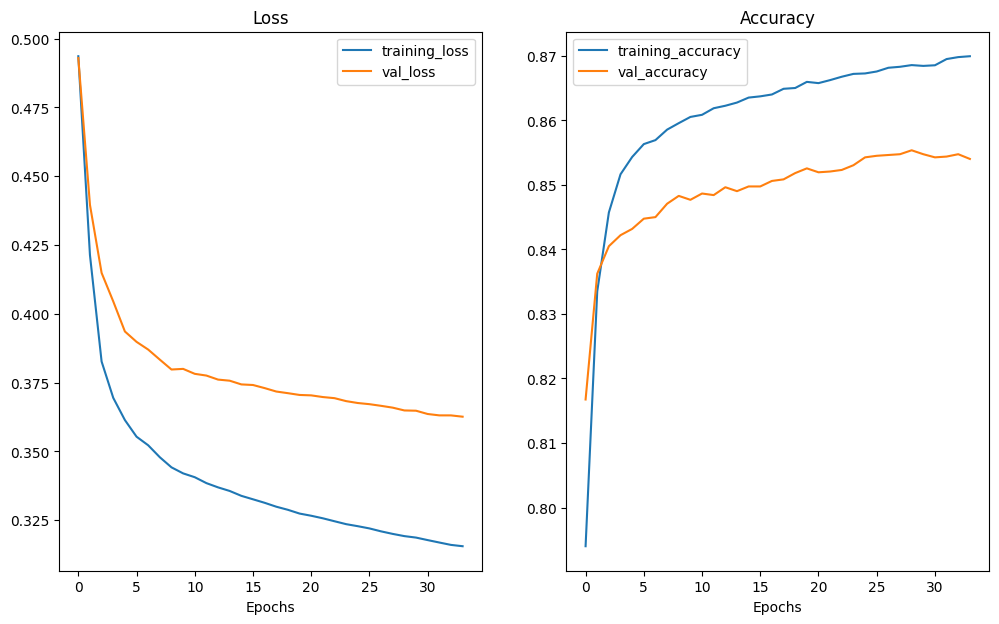

In [89]:
plot_loss_curves(history_cnn_stft)

## Loss Curves for Mel Spectrogram - CNN Model

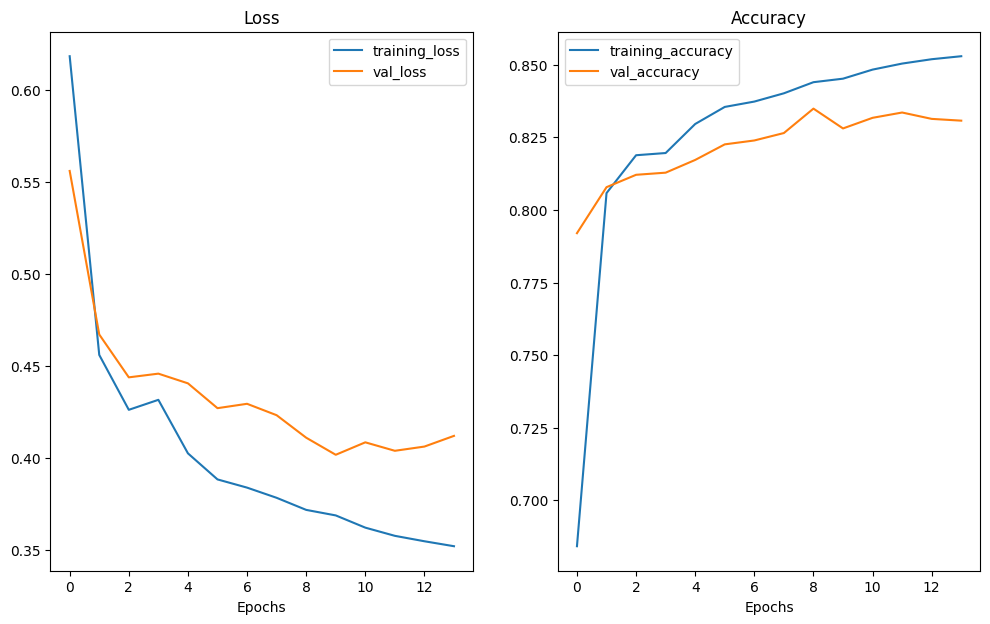

In [90]:
plot_loss_curves(history_cnn_mel_spec)

## Loss Curves for Mel Spectrogram RGB Image - CNN Model

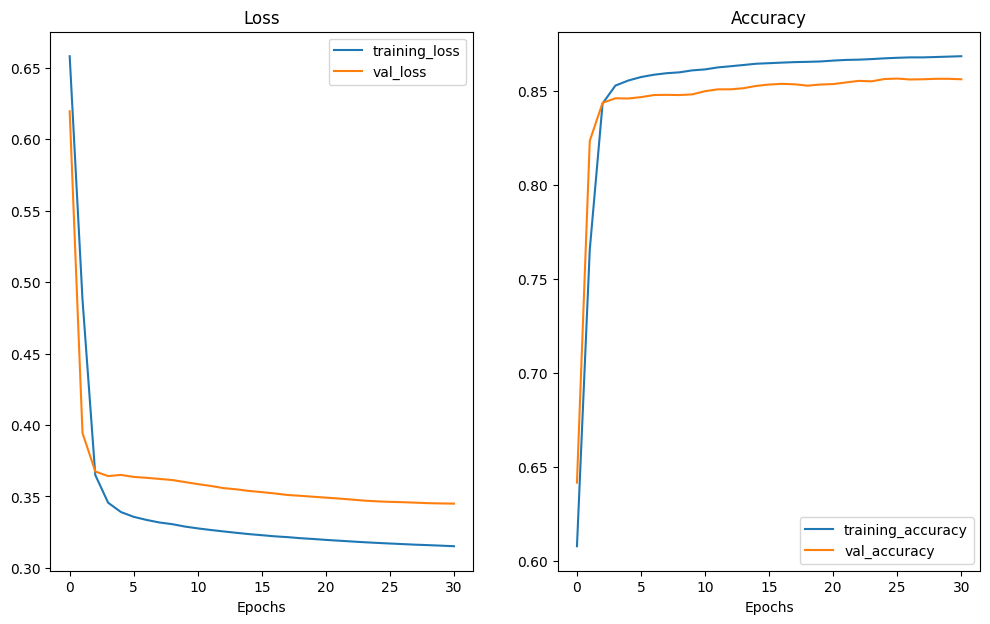

In [97]:
plot_loss_curves(history_cnn_rgb)

## Loss Curves for Mel Spectrogram RGB Image - EfficientNetB0 Model

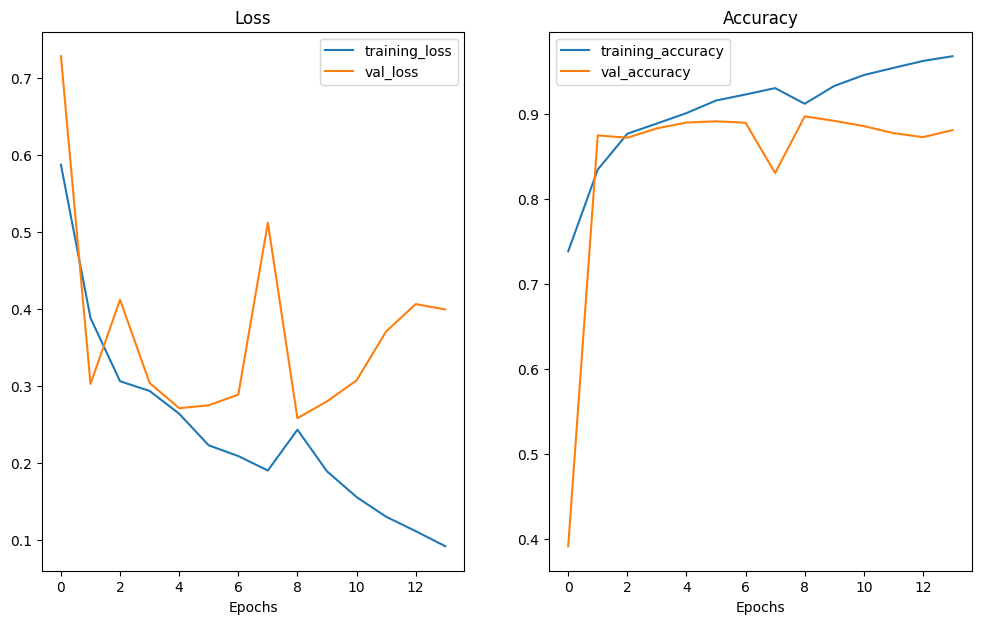

In [62]:
plot_loss_curves(history_mel_img_eff_b0)

## Loss Curves for Mel Spectrogram RGB Image - EfficientNetB3 Model

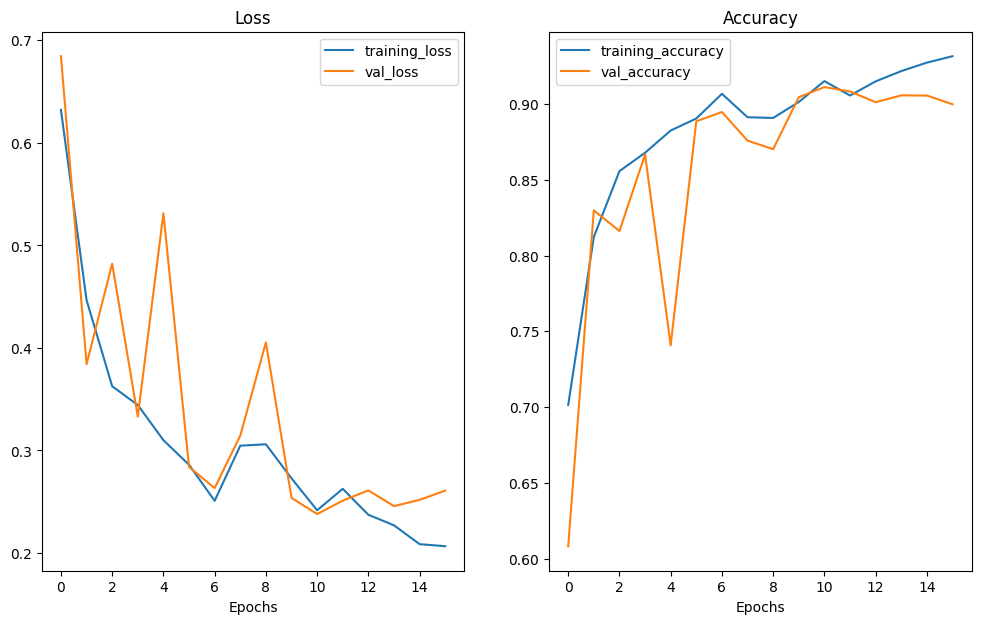

In [55]:
plot_loss_curves(history_mel_img_eff_b3)

## Loss Curves for Mel Spectrogram RGB Image - VGG19 Model

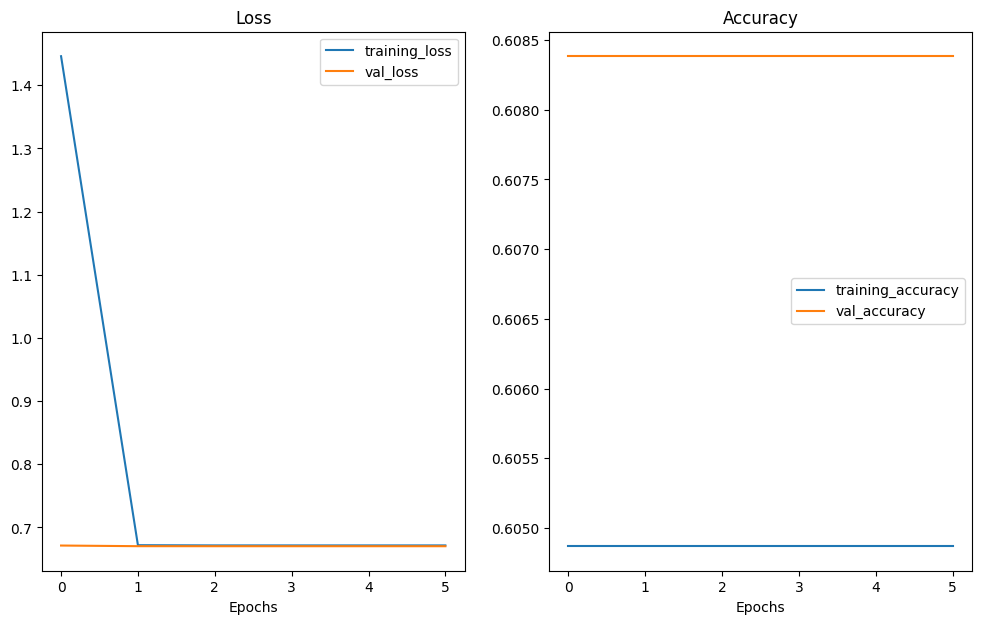

In [104]:
plot_loss_curves(history_mel_img_vgg_19)

## Loss Curves for Mel Spectrogram RGB Image - Resnet50v2 Model

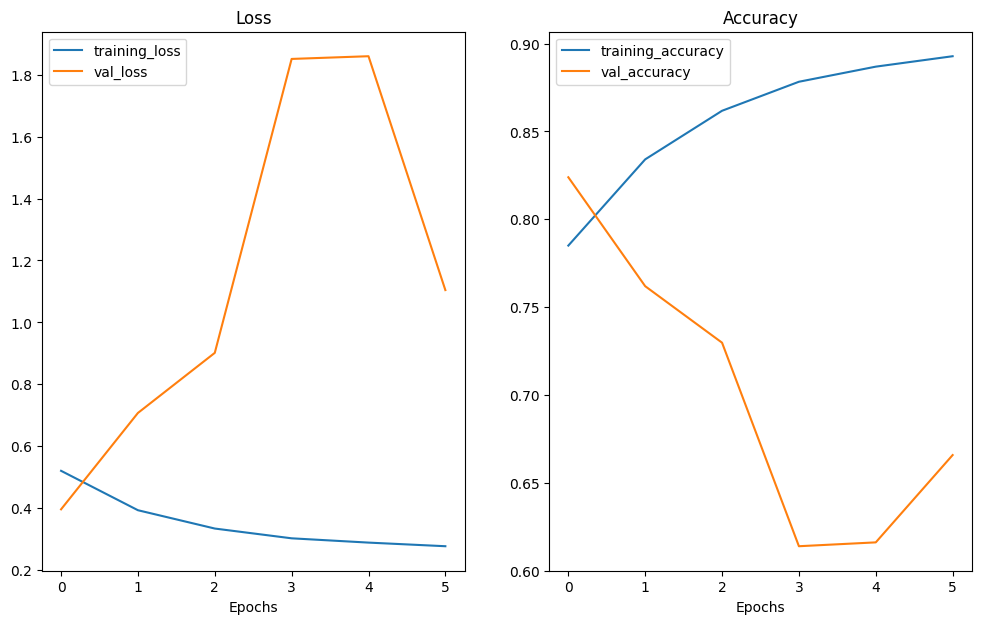

In [47]:
plot_loss_curves(history_mel_img_resnet_50v2)

## Load Saved Model - STFT - CNN

In [38]:
loaded_model_cnn_stft = tf.keras.models.load_model("saved_models/cnn_stft_model")

In [39]:
cnn_stft_results = loaded_model_cnn_stft.evaluate(val_dataset_stft)

2023-06-23 19:15:51.734528: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


65/65 [==============================] - 15s 16ms/step - loss: 0.3649 - accuracy: 0.8554


## Load Saved Model - Mel Spec - CNN


In [40]:
loded_model_cnn_mel_spec = tf.keras.models.load_model("saved_models/cnn_mel_spec")

In [41]:
cnn_mel_spec_results = loded_model_cnn_mel_spec.evaluate(val_dataset_mel_spec)

65/65 [==============================] - 77s 12ms/step - loss: 0.4112 - accuracy: 0.8349


## Load Saved Model - Mel Spec RGB - CNN

In [42]:
loaded_model_cnn_rgb = tf.keras.models.load_model("saved_models/cnn_rgb_model")

In [43]:
cnn_rgb_results = loaded_model_cnn_rgb.evaluate(val_mel_img_dataset)

65/65 [==============================] - 258s 12ms/step - loss: 0.3462 - accuracy: 0.8567


## Load Saved Model - Mel Spec RGB - EfficientNetB0

In [44]:
loaded_model_eff_b0_rgb = tf.keras.models.load_model("saved_models/eff_b0_model")

In [45]:
eff_b0_rgb_results = loaded_model_eff_b0_rgb.evaluate(val_mel_img_dataset)

65/65 [==============================] - 7s 84ms/step - loss: 0.2584 - accuracy: 0.8974


## Load Saved Model - Mel Spec RGB - EfficientNetB3

In [46]:
loaded_model_eff_b3_rgb = tf.keras.models.load_model("saved_models/eff_b3_model")

In [47]:
eff_b3_rgb_results = loaded_model_eff_b3_rgb.evaluate(val_mel_img_dataset)

65/65 [==============================] - 14s 180ms/step - loss: 0.2380 - accuracy: 0.9111


## Load Saved Model - Mel Spec RGB - VGG19

In [48]:
loaded_model_vgg_19_rgb = tf.keras.models.load_model("saved_models/vgg_19_model")

In [49]:
vgg_19_rgb_results = loaded_model_vgg_19_rgb.evaluate(val_mel_img_dataset)

65/65 [==============================] - 19s 269ms/step - loss: 0.6713 - accuracy: 0.6084


## Load Saved Model - Mel Spec RGB - Resnet50V2

In [50]:
loaded_model_resnet_50v2_rgb = tf.keras.models.load_model("saved_models/resnet_50v2_model")

In [51]:
resnet_50v2_results = loaded_model_resnet_50v2_rgb.evaluate(val_mel_img_dataset)

65/65 [==============================] - 9s 125ms/step - loss: 0.3966 - accuracy: 0.8239


In [60]:
model_results = pd.DataFrame(data={
    'cnn_stft': cnn_stft_results,
    'cnn_mel_spec': cnn_mel_spec_results,
    'cnn_rgb': cnn_rgb_results,
    'eff_b0_rgb': eff_b0_rgb_results,
    'eff_b3_rgb': eff_b3_rgb_results,
    'vgg_19_rgb': vgg_19_rgb_results,
    'resnet_50v2_rgb': resnet_50v2_results
})

,cnn_stft,cnn_mel_spec,cnn_rgb,eff_b0_rgb,eff_b3_rgb,vgg_19_rgb,resnet_50v2_rgb
loss,0.364896,0.411180,0.346235,0.258375,0.237996,0.671323,0.396558
accuracy,0.855367,0.834897,0.856708,0.897405,0.911052,0.608383,0.823931


In [54]:
cnn_rgb_results

,cnn_stft,cnn_mel_spec,cnn_rgb,eff_b0_rgb,eff_b3_rgb,vgg_19_rgb,resnet_50v2_rgb
0,0.364896,0.411180,0.346235,0.258375,0.237996,0.671323,0.396558
1,0.855367,0.834897,0.856708,0.897405,0.911052,0.608383,0.823931
